In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from math import ceil
from sklearn.metrics import confusion_matrix, classification_report
from mlxtend.plotting import plot_confusion_matrix

In [2]:
# Best parameters: {'batch_size': 64, 'image_size': 128, 'optimizer': 'sgd', 'epochs': 5}
batch_size = 64
img_height = 128
img_width = 128
DATA_DIR = "../chest_Xray/"
TEST = "test/"
TRAIN = "train/"
VAL = "val/"
NORMAL = "NORMAL"
PNEUMONIA = "PNEUMONIA"
NET = "NET"

In [3]:
# Créer un ensemble de données

train_ds = tf.keras.utils.image_dataset_from_directory(
  DATA_DIR +  TRAIN,
  validation_split=0.2,
  subset="training",
  seed=123,
  color_mode="grayscale",
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  DATA_DIR + VAL,
  validation_split=0.2,
  subset="validation",
  color_mode="grayscale",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 5216 files belonging to 2 classes.
Using 4173 files for training.
Found 17 files belonging to 2 classes.
Using 3 files for validation.


In [4]:
class_names = train_ds.class_names
num_classes = len(class_names)
print(class_names)

['NORMAL', 'PNEUMONIA']


In [5]:
# Configurer l'ensemble de données pour les performances

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [6]:
# Standardiser les données

normalization_layer = tf.keras.layers.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.9857537


In [7]:
# Augmentation des données

data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  1)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

In [8]:
# cree le modele

model = Sequential([
  data_augmentation,
  layers.Conv2D(16, 3, padding='same', activation='relu', input_shape=(img_height, img_width, 1)),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


In [9]:
# Compiler le modèle

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [10]:
# Résumé du modèle

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 128, 128, 1)       0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)       

In [11]:
# Create a callback allowing to save the best performing model
checkpoint = ModelCheckpoint("saved_model.model.h5", monitor='val_loss', verbose=1, save_best_only=True, min_delta = .002)

In [12]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=10)

In [13]:
lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                          patience=10)

In [14]:
# Former le modèle
epochs=5
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[checkpoint]
)

Epoch 1/5
66/66 [==============================] - ETA: 0s - loss: 11.8857 - accuracy: 0.7479
Epoch 1: val_loss improved from inf to 0.24703, saving model to saved_model.model.h5
66/66 [==============================] - 13s 191ms/step - loss: 11.8857 - accuracy: 0.7479 - val_loss: 0.2470 - val_accuracy: 1.0000
Epoch 2/5
66/66 [==============================] - ETA: 0s - loss: 0.2907 - accuracy: 0.8763
Epoch 2: val_loss improved from 0.24703 to 0.20005, saving model to saved_model.model.h5
66/66 [==============================] - 12s 185ms/step - loss: 0.2907 - accuracy: 0.8763 - val_loss: 0.2000 - val_accuracy: 1.0000
Epoch 3/5
66/66 [==============================] - ETA: 0s - loss: 0.2607 - accuracy: 0.8926
Epoch 3: val_loss improved from 0.20005 to 0.17702, saving model to saved_model.model.h5
66/66 [==============================] - 12s 183ms/step - loss: 0.2607 - accuracy: 0.8926 - val_loss: 0.1770 - val_accuracy: 1.0000
Epoch 4/5
66/66 [==============================] - ETA: 0s -

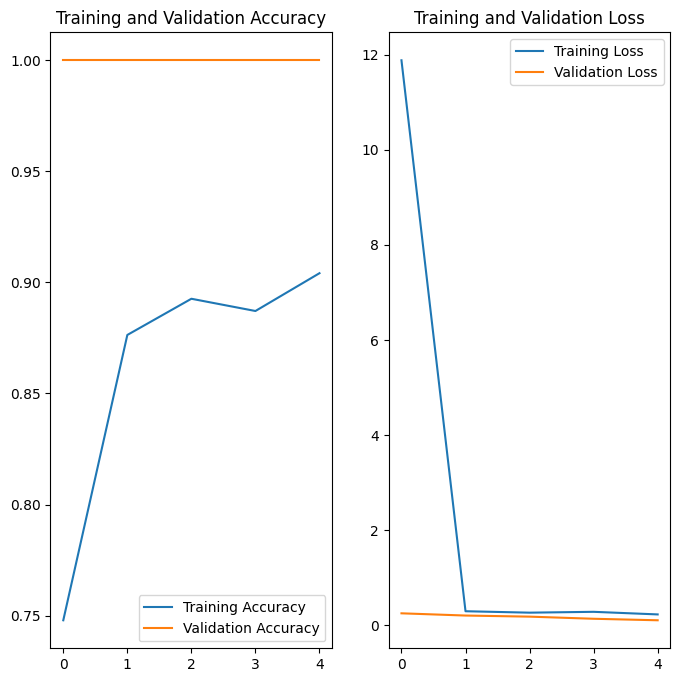

In [15]:
# Visualisez les résultats de l'entraînement

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [16]:
# test 
import os
  
  
for file in os.listdir(DATA_DIR + VAL + "/" + PNEUMONIA):
  img = tf.keras.utils.load_img(
      DATA_DIR + VAL + "/" + PNEUMONIA + "/" +file, target_size=(img_height, img_width), color_mode="grayscale"
  )
  img_array = tf.keras.utils.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0)

  predictions = model.predict(img_array)
  score = tf.nn.softmax(predictions[0])

  print(
      "This image most likely belongs to {} with a {:.2f} percent confidence."
      .format(class_names[np.argmax(score)], 100 * np.max(score))
  )
  
for file in os.listdir(DATA_DIR + VAL + "/" + NORMAL):
  img = tf.keras.utils.load_img(
      DATA_DIR + VAL + "/" + NORMAL + "/" +file, target_size=(img_height, img_width), color_mode="grayscale"
  )
  img_array = tf.keras.utils.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0)

  predictions = model.predict(img_array)
  score = tf.nn.softmax(predictions[0])

  print(
      "This image most likely belongs to {} with a {:.2f} percent confidence."
      .format(class_names[np.argmax(score)], 100 * np.max(score))
  )

1/1 [==============================] - 0s 64ms/step
This image most likely belongs to PNEUMONIA with a 99.26 percent confidence.
1/1 [==============================] - 0s 14ms/step
This image most likely belongs to PNEUMONIA with a 99.60 percent confidence.
1/1 [==============================] - 0s 15ms/step
This image most likely belongs to PNEUMONIA with a 99.39 percent confidence.
1/1 [==============================] - 0s 15ms/step
This image most likely belongs to PNEUMONIA with a 85.68 percent confidence.
1/1 [==============================] - 0s 15ms/step
This image most likely belongs to PNEUMONIA with a 98.01 percent confidence.
1/1 [==============================] - 0s 15ms/step
This image most likely belongs to PNEUMONIA with a 99.52 percent confidence.
1/1 [==============================] - 0s 15ms/step
This image most likely belongs to PNEUMONIA with a 95.90 percent confidence.
1/1 [==============================] - 0s 14ms/step
This image most likely belongs to PNEUMONIA w

In [17]:
from sklearn.metrics import confusion_matrix

val_images = []
val_labels = []
pred_labels = []

for file in os.listdir(DATA_DIR + TEST + "/" + PNEUMONIA):
  img = tf.keras.utils.load_img(
      DATA_DIR + TEST + "/" + PNEUMONIA + "/" +file, target_size=(img_height, img_width), color_mode="grayscale"
  )
  img_array = tf.keras.utils.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0)

  predictions = model.predict(img_array)
  score = tf.nn.softmax(predictions[0])

  val_images.append(file)
  val_labels.append(1)  # pneumonia
  pred_labels.append(np.argmax(score))

for file in os.listdir(DATA_DIR + TEST + "/" + NORMAL):
  img = tf.keras.utils.load_img(
      DATA_DIR + TEST + "/" + NORMAL + "/" +file, target_size=(img_height, img_width), color_mode="grayscale"
  )
  img_array = tf.keras.utils.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0)

  predictions = model.predict(img_array)
  score = tf.nn.softmax(predictions[0])

  val_images.append(file)
  val_labels.append(0)  # normal
  pred_labels.append(np.argmax(score))

conf_mat = confusion_matrix(val_labels, pred_labels)
print(conf_mat)

1/1 [==============================] - 0s 15ms/step
[[ 41 193]
 [  2 388]]


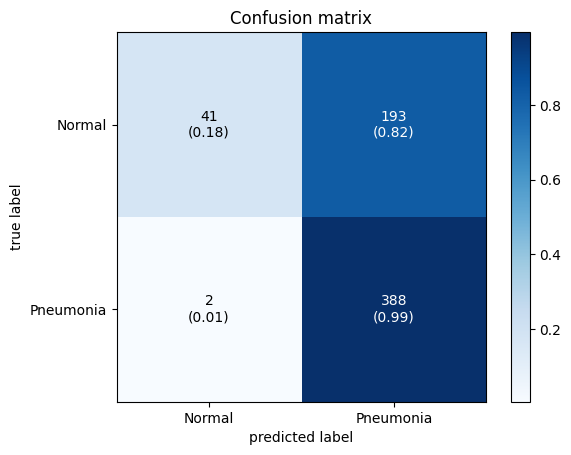

In [18]:
# Get the confusion matrix
fig, ax = plot_confusion_matrix(conf_mat=conf_mat,
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.title('Confusion matrix')
plt.xticks(range(2), ['Normal','Pneumonia'], fontsize=10)
plt.yticks(range(2), ['Normal','Pneumonia'], fontsize=10)

plt.show()